# Predict TripAdvisor Rating

# import

In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np 
import re
import json
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import unicodedata #для транслитерации не ASCII
import unidecode #для транслитерации не ASCII 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import itertools
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/lib/kaggle/gcp.py
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/opinionlexiconenglish/positive-words.txt
/kaggle/input/opinionlexiconenglish/neg_words.txt
/kaggle/working/requirements.txt
/kaggle/working/__notebook_source__.ipynb


In [163]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# - общую текущую дату
CURRENT_DATE = pd.to_datetime('29/11/2020')

In [164]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [165]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_in = pd.read_csv(DATA_DIR+'main_task.csv')
# Путь к датасету для которого требуется предсказать рейтинг
df_kagle = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#Путь к 'submission.csv'
submission_path = pd.read_csv(DATA_DIR+'sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_kagle['ForTrain'] = False # помечаем где у нас тест
df_kagle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df_in['ForTrain'] = True # помечаем где у нас трейн
df_in = df_in.append(df_kagle, sort=False).reset_index(drop=True)# объединяем

In [166]:
# Путь к датасету, содержащему слова с позитивной окраской
df_pos_words = pd.read_csv('/kaggle/input/opinionlexiconenglish/positive-words.txt',skiprows=34, names=['word'])
pos_words_list = df_pos_words['word'].to_list() 

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!


# Знакомимся с данными

In [167]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Rating               50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
ForTrain             50000 non-null bool
dtypes: bool(1), float64(3), object(7)
memory usage: 3.9+ MB


In [168]:
df_in.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,ForTrain
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,True
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,True
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,True
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,True
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,True


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [169]:
# Выбираем нужные для последующего анализа столбцы
df = df_in[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range', 'Cuisine Style', 'Reviews', 'Restaurant_id', 'ID_TA', 'ForTrain' ]].copy()

In [170]:
df.sample(5)

,Ranking,Rating,Number of Reviews,City,Price Range,Cuisine Style,Reviews,Restaurant_id,ID_TA,ForTrain
18250,8549.0,2.0,94.0,Madrid,NaN,['International'],"[[], []]",id_8542,d953567,True
42246,4571.0,0.0,17.0,Berlin,NaN,NaN,"[['GDR - Funk meets Molecular Cuisine', 'East ...",id_2246,d2020466,False
4608,430.0,5.0,25.0,Oporto,$,"['Mediterranean', 'European', 'Portuguese']","[['Great seafood', 'Very good indeed'], ['01/0...",id_429,d9561344,True
16341,1187.0,5.0,NaN,Edinburgh,NaN,NaN,"[[], []]",id_1186,d8686804,True
28637,644.0,4.5,22.0,Athens,$$ - $$$,"['Mediterranean', 'Greek', 'European']","[['Excellent', 'All time classic'], ['11/06/20...",id_643,d814051,True


In [171]:
df.Reviews[1]

"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Обработка данных



In [172]:
# Посмотрим на признаки и количество пропусков (NaN)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Ranking              50000 non-null float64
Rating               50000 non-null float64
Number of Reviews    46800 non-null float64
City                 50000 non-null object
Price Range          32639 non-null object
Cuisine Style        38410 non-null object
Reviews              49998 non-null object
Restaurant_id        50000 non-null object
ID_TA                50000 non-null object
ForTrain             50000 non-null bool
dtypes: bool(1), float64(3), object(6)
memory usage: 3.5+ MB


In [173]:
# Посмотрим на признаки и к-во уникальных значений
df.nunique(dropna=False)

Ranking              12975
Rating                  10
Number of Reviews     1574
City                    31
Price Range              4
Cuisine Style        10732
Reviews              41858
Restaurant_id        13094
ID_TA                49963
ForTrain                 2
dtype: int64

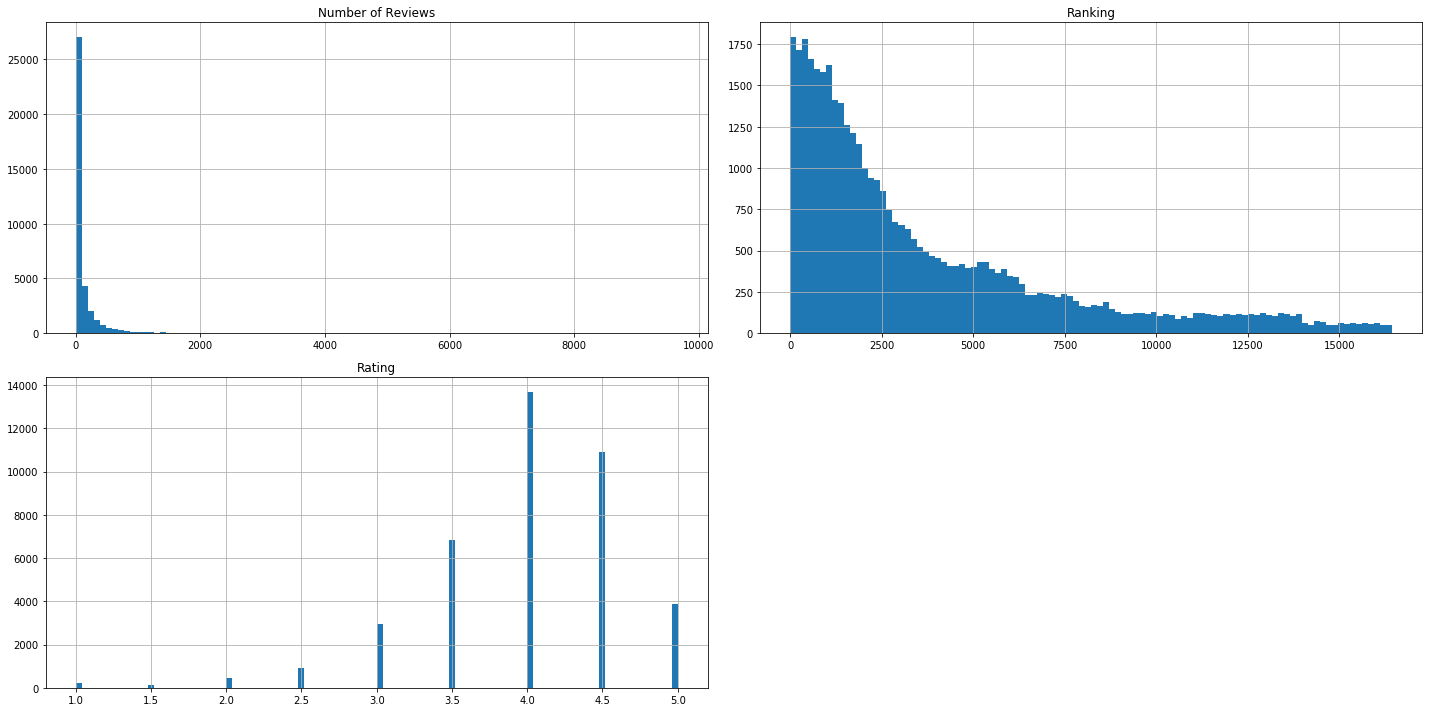

In [174]:
# Посмотрим на гистограммы числовых признаков
df[df.ForTrain][['Ranking', 'Rating', 'Number of Reviews','Price Range', 'Restaurant_id']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

# Restaurant_id

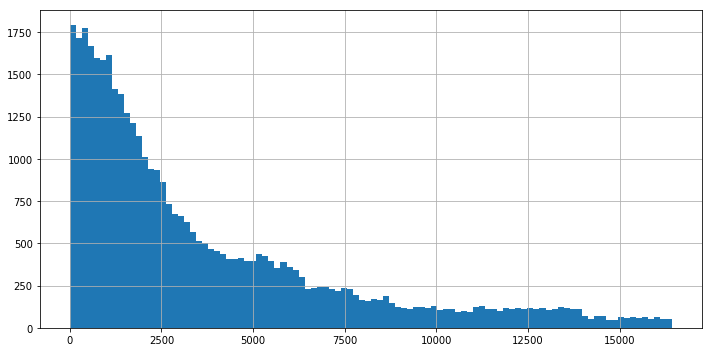

In [175]:
df[df.ForTrain]['Restaurant_id'].apply(lambda x: x.split('_')[1]).astype(int).hist(figsize=(10,5), bins=100);
plt.tight_layout()

# ID_TA

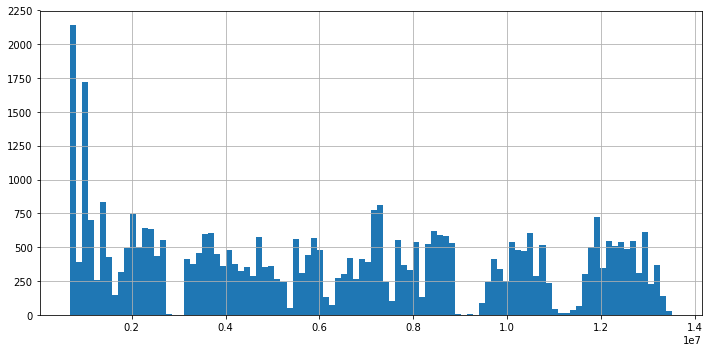

In [176]:
df[df.ForTrain]['ID_TA'].apply(lambda x: x.replace('d','')).astype(int).hist(figsize=(10, 5), bins=100);
plt.tight_layout()

In [177]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: x[1:]) 
df['ID_TA'] 

0         1912643
1         7992032
2         8632781
3         1358776
4         6864963
           ...   
49995    11916827
49996    12701633
49997    13198194
49998     3862815
49999    10342814
Name: ID_TA, Length: 50000, dtype: object

# Reviews

In [178]:
# Reviews - убираем NaN и обрабатываем текст отзывов 
df['Reviews_txt_NaN'] = df['Reviews'].apply(lambda x: x ==  '[[], []]')

In [179]:
df['Reviews'] = df['Reviews'].fillna('[[], []]')

# Price Range

In [180]:
# Перекодируем Price Range и удаляем NaN
cleanup_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # чаще всего встречается "$$ - $$$" == 2
df['Price Range NAN'] = df['Price Range'].isna()
df.replace(cleanup_nums, inplace=True)

# Cuisine Style

In [181]:
# Получаем список кухонь в виде: cuisines[0] - list of cusines, если был NaN, то возвращается 'Regionl Cusine' - как самая популярная в регионе/городе/стране
def get_cuisines(cuisines):
  
    if cuisines == 'NaN': return ['Regionl Cusine']#['Vegetarian Friendly'] # 'Vegetarian Friendly' - самая популярная
    if  cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['Regionl Cusine'] #return ['Vegetarian Friendly']

In [182]:
# Получаем количество кухонь

allCusines = []
def cuisine_styles_count(row):
   
    global allCusines
    cusines = get_cuisines(row['Cuisine Style'])
    
    if row['Cuisine Style'] != 'NaN':    
        cusines = get_cuisines(row['Cuisine Style'])
        allCusines.extend(cusines)
        cuisines_count =len(cusines)
    else:
        cuisines_count = 1

    return cuisines_count

In [183]:
# Получаем Cuisines Count, самую популярную кухню, среднее к-во кухонь в ресторане и устраняем NaN
df['Cuisine Style NAN'] = df['Cuisine Style'].isna()
df['Cuisine Style'] = df['Cuisine Style'].fillna('NaN')
df['Cuisines Count'] = df.apply(cuisine_styles_count, axis=1)

most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
average_cousines_count = np.round(df['Cuisines Count'].mean())
print(most_popular_cusine)
print(average_cousines_count)

Vegetarian Friendly
3.0


In [184]:
#allCusines

# Number of Reviews

In [185]:
# Number of Reviews
df['Number of Reviews NAN'] = df['Number of Reviews'].isna()
replace_val = df['Number of Reviews'].mean()
replace_val = np.round(replace_val)
df['Number of Reviews'] = df['Number of Reviews'].fillna(replace_val)

In [186]:
df.sample(5)

,Ranking,Rating,Number of Reviews,City,Price Range,Cuisine Style,Reviews,Restaurant_id,ID_TA,ForTrain,Reviews_txt_NaN,Price Range NAN,Cuisine Style NAN,Cuisines Count,Number of Reviews NAN
25543,1290.0,4.0,31.0,Brussels,2,['Italian'],"[['Very good mom & pop Italian', 'Best italian...",id_1289,940361,True,False,False,False,1,False
39965,5722.0,5.0,124.0,Rome,2,NaN,"[[], []]",id_5720,793376,True,True,True,True,1,True
28129,1305.0,4.5,19.0,Brussels,2,NaN,"[['A pleasant suburban restaurant', 'great ser...",id_1304,1828532,True,False,True,True,1,False
11451,6738.0,3.0,5.0,Barcelona,2,NaN,"[['Dishonest and expensive', 'restaurant of Ho...",id_6737,997413,True,False,True,True,1,False
34513,1446.0,4.0,760.0,Rome,2,"['Italian', 'Mediterranean', 'Soups', 'Vegetar...","[['Classic Tuscan Fare in Rome', 'Saturday Eve...",id_1445,716329,True,False,False,False,5,False


# EDA
Посмотрим распределение признака

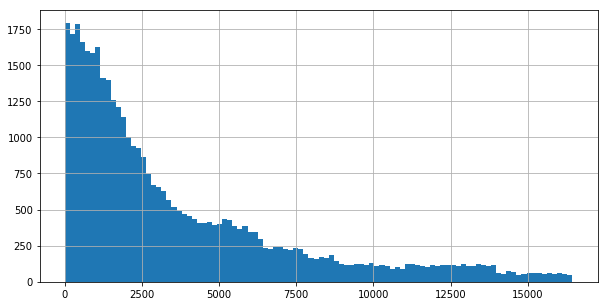

In [187]:
plt.rcParams['figure.figsize'] = (10,5)
df[df.ForTrain]['Ranking'].hist(bins=100);

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

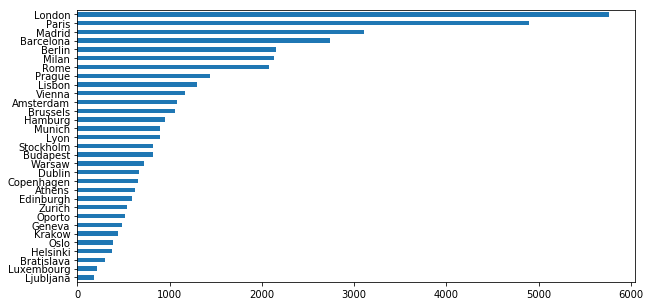

In [188]:
df[df.ForTrain]['City'].value_counts(ascending=True).plot(kind='barh');

Посмотрим, как изменится распределение в большом городе:

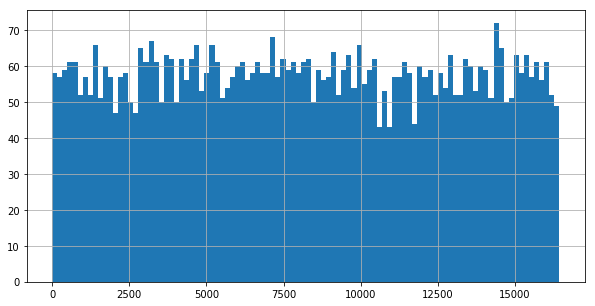

In [189]:
df[df.ForTrain]['Ranking'][df[df.ForTrain]['City'] =='London'].hist(bins=100);

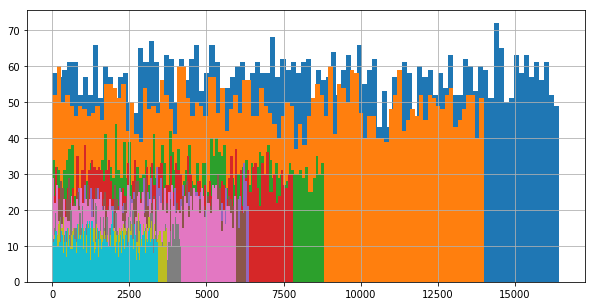

In [190]:
# посмотрим на топ 10 городов
for x in (df[df.ForTrain]['City'].value_counts())[0:10].index:
    df[df.ForTrain]['Ranking'][df[df.ForTrain]['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. Для нормализации Rankin можно использовать новый признак, например, количество ресторанов на 1000 жителей, а не просто количество жителей


# Целевая переменная Rating

Посмотрим распределение целевой переменной

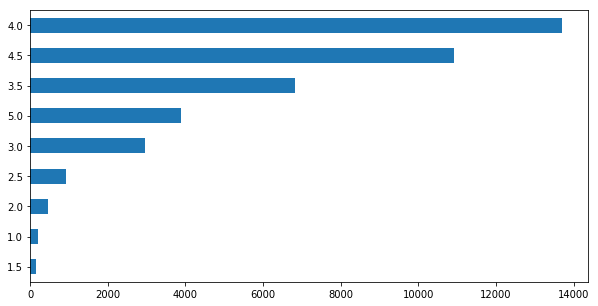

In [191]:
df[df.ForTrain]['Rating'].value_counts(ascending=True).plot(kind='barh');

Посмотрим распределение целевой переменной относительно признака

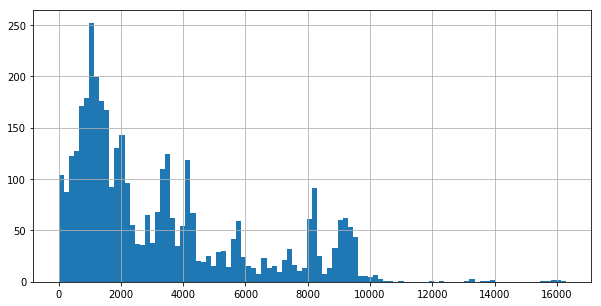

In [192]:
df[df.ForTrain]['Ranking'][df[df.ForTrain]['Rating'] == 5].hist(bins=100);

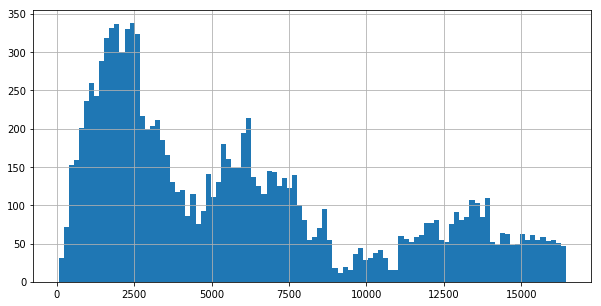

In [193]:
df[df.ForTrain]['Ranking'][df[df.ForTrain]['Rating'] < 4].hist(bins=100);

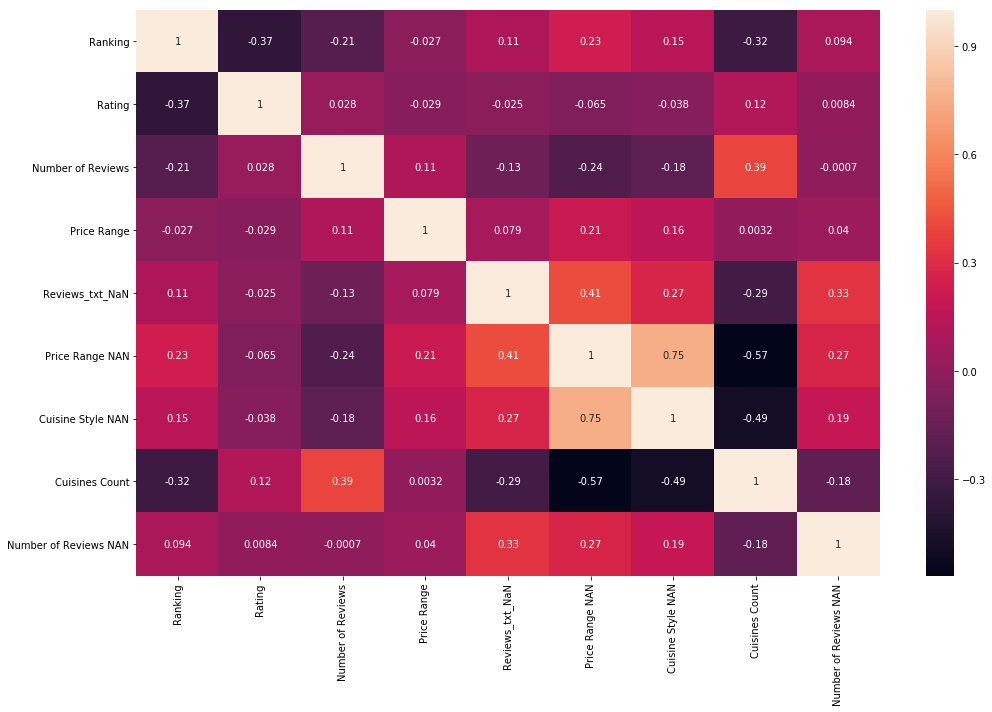

In [194]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df[df.ForTrain].drop(['ForTrain'], axis=1).corr(),annot=True)
plt.tight_layout()

Поищем другие или дополнительные признаки, привлечем внешние данные

In [195]:
population_city_dict = {    
    'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Edinburgh': .476100,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }

In [196]:
# Вычисляем к-во ресторанов для города в каждой строке
restorants_in_city = df.groupby('City')['Ranking'].count().to_dict()
df['Restaurants Count'] = df['City'].map(restorants_in_city)
# df['Restaurants Count']

In [197]:
# Вычисляем население (в тыс. чел) для города в каждой строке
df['Population'] = df["City"].map(population_city_dict)
#df['Population']

In [198]:
# Вычисляем к-во ресторанов на 1000 чел для города в каждой строке
df['Restaurants for Population'] = df['Restaurants Count'] / (df['Population']*1000) 
#df['Restaurants for Population']

## Flags

In [199]:
# Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня; isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
df['isMostPopCusine'] = df['Cuisine Style'].apply(lambda x: 1 if most_popular_cusine in x else 0 )
df['isMultyCusine'] = df['Cuisines Count'].apply(lambda x: 1 if  x >= average_cousines_count else 0 )

# Reviews 

Обработка отзывов

Получаем review в виде:
- review['reviews_txt'][1] - list of reviews
- review['reviews_dt'][1] - list of reviews dates
 

In [200]:
def get_reviews(rev):
    if  not pd.isna(rev): 
        rev = str(rev).replace("'",'"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[','[').replace(']]',']')
        d = json.loads(rev)

        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split('/')[2])==4 else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

### RevTimeDelta - время между review в днях

Вычисляем время между review в днях

Не заработало


In [201]:
# RevTimeDelta - время между review в днях

def rev_time_delta(reviews):
    if (pd.notna(reviews)):
        reviews_dt_list = get_reviews(reviews)['reviews_dt']
        if reviews_dt_list:
            return (max(reviews_dt_list) - min(reviews_dt_list)).days
        else:
            return dt.timedelta(days=3650).days
    else:
        return dt.timedelta(days=3650).days


In [202]:
# NewestReviewDate - время, прошедшее со момента последнего review до '22/02/2020'
#df['NewestReviewDate'] = df['Reviews'].apply(lambda x: get_reviews(x)['reviews_dt'])
#df['NewestReviewDate'] = df['NewestReviewDate'].apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
#df['NewestReviewDate'] = df['NewestReviewDate'].fillna(dt.date(1970,1,1))
#df['NewestReviewDate'] = df['NewestReviewDate'].apply(lambda x: (CURRENT_DATE.date()-x).total_seconds()//86400)

In [203]:
#df['NewestReviewSeason'] = df['Reviews'].apply(lambda x: get_reviews(x)['reviews_dt'])
#df['NewestReviewSeason'] = df['NewestReviewSeason'].apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
#df['NewestReviewSeason'] = df['NewestReviewSeason'].fillna(dt.date(2020,2,22))
#df['NewestReviewSeason'] = df['NewestReviewSeason'].apply(lambda x: get_season(x))

In [204]:
#df['RevTimeDelta'] = df['Reviews'].apply(rev_time_delta)

# Не получилось

In [205]:
# Количество позитивных слов в отзывах

def count_positive_words_proportion(reviews):
    pos_words_count = 0
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review=set(words).intersection(pos_words_list)
    for word in words:
        if word in pos_words_list:
            #print(word)
            pos_words_count +=1  
    return np.round(pos_words_count/words_count,2)

In [206]:
#  Список уникальных позитивных слов в приведенных отзывах
def list_positive_words(reviews): 
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review=set(words).intersection(pos_words_list)
    #print(len(pos_words_in_review))
    if (len(pos_words_in_review) == 0):
        return np.NAN
    else:
        return list(pos_words_in_review)

In [207]:
def createWordList(line):
    wordList2 =[]
    wordList1 = line.split()
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        wordList2.append(cleanWord.lower())
    return wordList2

In [209]:
# Количество позитивных слов в представленных отзывах
#df['PositiveWords'] = df['Reviews'].apply(lambda x: count_positive_words_proportion(x))
# Не получилось, что-то с Json

In [ ]:
# df['PositiveWords in Reviews'] = df['PositiveWords'] / df['Number of Reviews']

# Cusine

In [237]:
df['Most Common Cusine in City'] = df['City'].apply(lambda x: cusines_in_city[x].most_common(1)[0][0])
#df['Most Common Cusine in City']

In [217]:
df['Cuisine Style'] = df.apply(lambda x: x['Cuisine Style'] if x['Cuisine Style NAN'] ==False else [x['Most Common Cusine in City']], axis=1)

Возвращаем список кухонь, входящих в основной список кухонь,для остальных Other


In [221]:
def is_cuisine_top_N(cs):
    
    c = get_cuisines(cs)
    c = set(c)

    shared_cousines=()
    shared_cousines=c.intersection(topNcusines)

    if len(shared_cousines) != len(c):
        shared_cousines = list(shared_cousines)
        shared_cousines.extend(['Other'])

    return list(shared_cousines)

In [235]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other - это почти всегда дает улучшение предсказания
N=10 #!!!

s = df['Cuisine Style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
df['Cuisine top N'] =df['Cuisine Style'].apply(lambda x: is_cuisine_top_N(x))
#df['Cuisine top N']

# Средняя цена в городе

In [241]:
# Средняя цена в городе
price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
df['Price in City'] = df['City'].map(price_in_city_dict)
#df['Price in City']

### Устранили NaN и сгенерили новые признаки(пока без dummies), посмотрим какие из них подходят

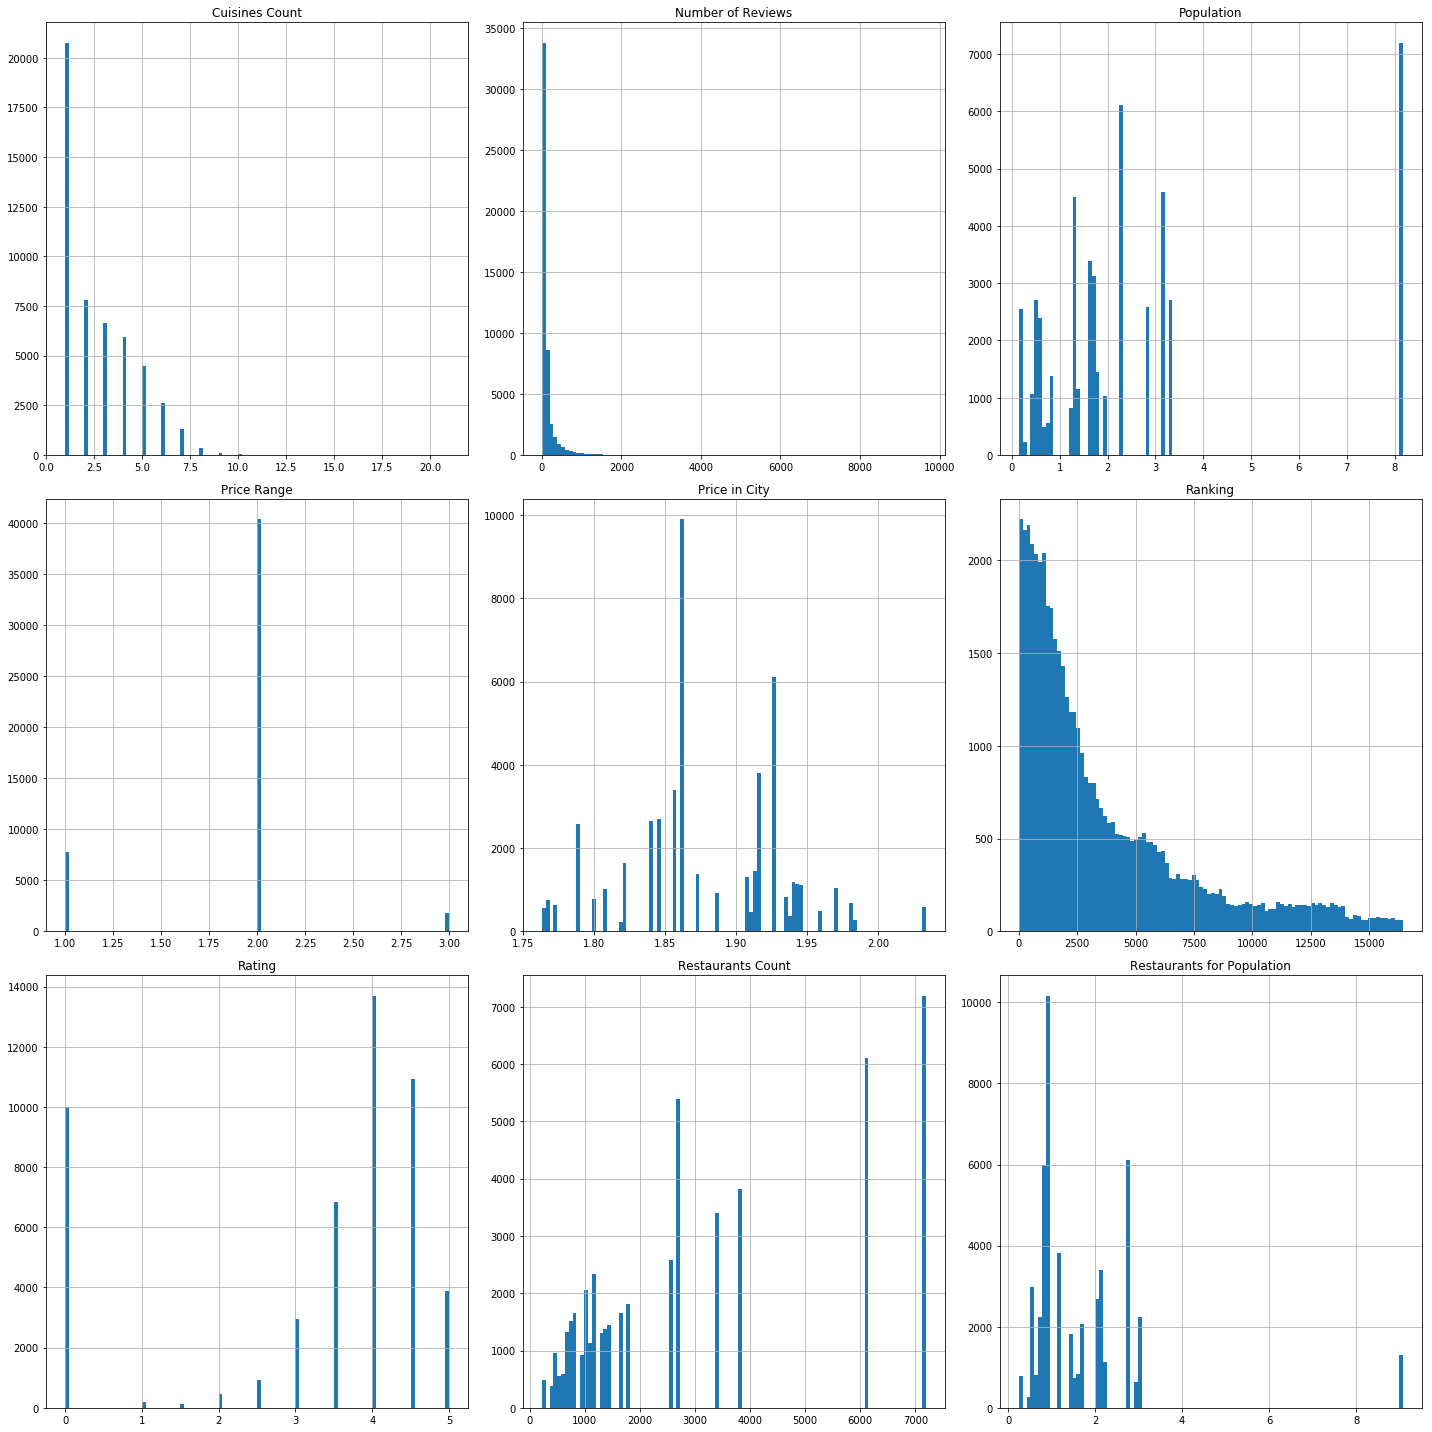

In [225]:
df[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range',
        'Restaurant_id', 'Restaurants Count', 'Population', 'Restaurants for Population',
         'Cuisines Count', 'Price in City']].hist(figsize=(20, 20), bins=100);
plt.tight_layout()

### Собираем Dummies

In [238]:
# Собираем Dummies: city, price_range, country_range, Cuisine top N

dff = pd.get_dummies(df['Cuisine top N'].apply(pd.Series).stack()).sum(level=0)
df_mcc = pd.get_dummies(df['Most Common Cusine in City'], prefix = 'MCC')
#df_city = pd.get_dummies(df['City'], prefix = 'City Range')
df_price_range = pd.get_dummies(df['Price Range'], prefix = 'Price Range') 
#df_country_range = pd.get_dummies(df['Country'], prefix = 'Country Range',) 

#df['PositiveWordsList'] = df['PositiveWordsList'].fillna('NAN')
#df_positive_words_range = pd.get_dummies(df['PositiveWordsList'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)


df1 = pd.concat([df,dff], axis=1)
df1 = pd.concat([df1,df_city], axis=1)
df1 = pd.concat([df1,df_price_range], axis=1)
#df1 = pd.concat([df1,df_country_range], axis=1)
df1 = pd.concat([df1,df_mcc], axis=1)
#df1 = pd.concat([df1,df_positive_words_range], axis=1)

#df1 = pd.concat([df1,df_season_range], axis=1)

#df1 = pd.concat([df1,df_restid_range], axis=1)

cols_cuisine_style = dff.columns
cols_city = df_city.columns
cols_price_range =  df_price_range.columns
#cols_country_range =  df_country_range.columns
cols_mcc =  df_mcc.columns
#cols_positive_words = df_positive_words_range.columns
#cols_season = df_season_range.columns
#cols_restid_range =  df_restid_range.columns

In [244]:
# Собираем признаки и разбиваем датафрейм на части, необходимые для обучения и тестирования модели
columns = [ 'isMultyCusine', 'Price Range NAN', 'Cuisine Style NAN', 'Number of Reviews NAN', 'Number of Reviews', 'Restaurants Count', 'Cuisines Count', 'Ranking', 'Cusines Count In City', 'ID_TA', 'Price in City',  'Cuisine Style NAN','Population', 'Restaurants for Population',  ]

#columns = [ 'isMultyCusine', 'Price Range NAN', 'Cuisine Style NAN', 'Number of Reviews NAN', 'Number of Reviews', 'Restaurants Count', 'Cuisines Count', 'RevTimeDelta',        'NewestReviewDate', 'PositiveWords',  'Weighed Rank', 'Ranking', 'Weighed Rank by Population',  'Cusines Count In City', 'WRR', 'ID_TA', 'Weighed Rank min max', 'Price in City', 'Weighed Rank by Population',  ]

columns.extend(cols_price_range.tolist())
columns.extend(cols_cuisine_style.tolist())
columns.extend(cols_city.tolist())
#columns.extend(cols_country_range.tolist())

#columns.extend(cols_positive_words.tolist())



In [245]:
#Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
X = df1[df1.ForTrain][columns]

y = df1[df1.ForTrain]['Rating']

In [246]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [247]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Model 

In [248]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [249]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [250]:
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [252]:
# Округляем до 0.5
def round_of_rating(number):
   
    return np.round(number * 2) / 2


In [ ]:
y_pred_old = y_pred.copy()
y_pred = round_of_rating(y_pred) 

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred),  metrics.mean_absolute_error(y_test, y_pred_old) )

In [ ]:
#Вычисляем коэффициент детерминации:
R_2 = metrics.r2_score(y_test, y_pred)
print(R_2)

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh');

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
# Предсказываем рейтинги на датасете для предсказаний (ForTrain == False)
X_submission = df1[df1.ForTrain == False][columns]
y_pred_submission = round_of_rating(regr.predict(X_submission))

In [ ]:
# Формируем датасет с предсказаниями Restaurant_id -- Rating
submission_df = pd.DataFrame()
submission_df['Restaurant_id'] = df1[df1.ForTrain == False]['Restaurant_id']
submission_df['Rating'] = y_pred_submission
submission_df.head(15)

# Проверяем годность предсказаний
Если распределения достаточно похожи, то - ОК!

In [ ]:
print('Тренировочный датасет')
df[df.ForTrain].Rating.value_counts()

In [ ]:
print('Предсказания масштабированные в 4 раза')
submission_df.Rating.value_counts()*4

In [ ]:
# Сохраняем предсказания
submission_df.to_csv('submission.csv', index=False)